In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalAvgPool1D()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 32)    128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 32)    192         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 16000, 32)    128         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 32)    0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 32)    192         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_18 (Batc (None, 16000, 32)    128         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_18[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6881 - acc: 0.1421
Epoch 00001: val_loss improved from inf to 2.53409, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_3_conv_checkpoint/001-2.5341.hdf5
36805/36805 [==============================] - 31s 829us/sample - loss: 2.6882 - acc: 0.1421 - val_loss: 2.5341 - val_acc: 0.2958
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.4682 - acc: 0.2104
Epoch 00002: val_loss improved from 2.53409 to 2.30702, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_3_conv_checkpoint/002-2.3070.hdf5
36805/36805 [==============================] - 28s 752us/sample - loss: 2.4682 - acc: 0.2103 - val_loss: 2.3070 - val_acc: 0.3634
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.3535 - acc: 0.2426
Epoch 00003: val_loss improved from 2

Epoch 22/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.7208 - acc: 0.4429
Epoch 00022: val_loss improved from 1.51435 to 1.51294, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_3_conv_checkpoint/022-1.5129.hdf5
36805/36805 [==============================] - 28s 752us/sample - loss: 1.7212 - acc: 0.4428 - val_loss: 1.5129 - val_acc: 0.5723
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7020 - acc: 0.4525
Epoch 00023: val_loss improved from 1.51294 to 1.47630, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_3_conv_checkpoint/023-1.4763.hdf5
36805/36805 [==============================] - 28s 751us/sample - loss: 1.7020 - acc: 0.4525 - val_loss: 1.4763 - val_acc: 0.5949
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.6934 - acc: 0.4548
Epoch 00024: val_loss improved from 1.47630 to 1.46509, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_

36800/36805 [============================>.] - ETA: 0s - loss: 1.5245 - acc: 0.5150
Epoch 00046: val_loss did not improve from 1.29336
36805/36805 [==============================] - 27s 746us/sample - loss: 1.5245 - acc: 0.5149 - val_loss: 1.2968 - val_acc: 0.6257
Epoch 47/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.5237 - acc: 0.5131
Epoch 00047: val_loss did not improve from 1.29336
36805/36805 [==============================] - 28s 748us/sample - loss: 1.5239 - acc: 0.5130 - val_loss: 1.2937 - val_acc: 0.6166
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5123 - acc: 0.5165
Epoch 00048: val_loss improved from 1.29336 to 1.25037, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_3_conv_checkpoint/048-1.2504.hdf5
36805/36805 [==============================] - 27s 747us/sample - loss: 1.5123 - acc: 0.5165 - val_loss: 1.2504 - val_acc: 0.6448
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 1.4214 - acc: 0.5509
Epoch 00073: val_loss did not improve from 1.17514
36805/36805 [==============================] - 28s 750us/sample - loss: 1.4215 - acc: 0.5508 - val_loss: 1.2086 - val_acc: 0.6191
Epoch 74/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.4209 - acc: 0.5488
Epoch 00074: val_loss improved from 1.17514 to 1.14829, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_3_conv_checkpoint/074-1.1483.hdf5
36805/36805 [==============================] - 28s 749us/sample - loss: 1.4205 - acc: 0.5489 - val_loss: 1.1483 - val_acc: 0.6723
Epoch 75/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.4150 - acc: 0.5494
Epoch 00075: val_loss did not improve from 1.14829
36805/36805 [==============================] - 28s 750us/sample - loss: 1.4148 - acc: 0.5493 - val_loss: 1.1926 - val_acc: 0.6480
Epoch 76/500
36736/36805 [============================>.] - ETA: 0s -

Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3548 - acc: 0.5716
Epoch 00101: val_loss did not improve from 1.10154
36805/36805 [==============================] - 27s 746us/sample - loss: 1.3550 - acc: 0.5716 - val_loss: 1.5104 - val_acc: 0.5313
Epoch 102/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3535 - acc: 0.5729
Epoch 00102: val_loss did not improve from 1.10154
36805/36805 [==============================] - 27s 746us/sample - loss: 1.3540 - acc: 0.5727 - val_loss: 1.2002 - val_acc: 0.6173
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3547 - acc: 0.5737
Epoch 00103: val_loss did not improve from 1.10154
36805/36805 [==============================] - 27s 744us/sample - loss: 1.3547 - acc: 0.5737 - val_loss: 2.2215 - val_acc: 0.4142
Epoch 104/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3546 - acc: 0.5713
Epoch 00104: val_loss did not improve from 1.10154
36805/36805 [=

Epoch 129/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3072 - acc: 0.5862
Epoch 00129: val_loss did not improve from 1.04343
36805/36805 [==============================] - 27s 745us/sample - loss: 1.3075 - acc: 0.5861 - val_loss: 1.0479 - val_acc: 0.6935
Epoch 130/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3049 - acc: 0.5918
Epoch 00130: val_loss did not improve from 1.04343
36805/36805 [==============================] - 27s 747us/sample - loss: 1.3049 - acc: 0.5918 - val_loss: 1.0705 - val_acc: 0.6841
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2993 - acc: 0.5909
Epoch 00131: val_loss did not improve from 1.04343
36805/36805 [==============================] - 27s 746us/sample - loss: 1.2993 - acc: 0.5909 - val_loss: 1.4624 - val_acc: 0.5309
Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3035 - acc: 0.5871
Epoch 00132: val_loss did not improve from 1.04343
36805/36805 [=

36736/36805 [============================>.] - ETA: 0s - loss: 1.2674 - acc: 0.5997
Epoch 00157: val_loss did not improve from 1.01137
36805/36805 [==============================] - 28s 748us/sample - loss: 1.2675 - acc: 0.5998 - val_loss: 1.4484 - val_acc: 0.4934
Epoch 158/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2648 - acc: 0.5985
Epoch 00158: val_loss did not improve from 1.01137
36805/36805 [==============================] - 27s 746us/sample - loss: 1.2642 - acc: 0.5987 - val_loss: 1.0210 - val_acc: 0.7009
Epoch 159/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2739 - acc: 0.5989
Epoch 00159: val_loss did not improve from 1.01137
36805/36805 [==============================] - 28s 750us/sample - loss: 1.2743 - acc: 0.5990 - val_loss: 1.5886 - val_acc: 0.5050
Epoch 160/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2641 - acc: 0.6060
Epoch 00160: val_loss did not improve from 1.01137
36805/36805 [===============

Epoch 185/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2485 - acc: 0.6091
Epoch 00185: val_loss did not improve from 0.98671
36805/36805 [==============================] - 27s 746us/sample - loss: 1.2485 - acc: 0.6091 - val_loss: 1.1010 - val_acc: 0.6327
Epoch 186/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2406 - acc: 0.6078
Epoch 00186: val_loss did not improve from 0.98671
36805/36805 [==============================] - 27s 745us/sample - loss: 1.2408 - acc: 0.6079 - val_loss: 0.9926 - val_acc: 0.7144
Epoch 187/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2476 - acc: 0.6128
Epoch 00187: val_loss improved from 0.98671 to 0.97086, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_3_conv_checkpoint/187-0.9709.hdf5
36805/36805 [==============================] - 28s 750us/sample - loss: 1.2475 - acc: 0.6127 - val_loss: 0.9709 - val_acc: 0.7265
Epoch 188/500
36736/36805 [==========================

Epoch 213/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2253 - acc: 0.6180
Epoch 00213: val_loss did not improve from 0.93351
36805/36805 [==============================] - 27s 747us/sample - loss: 1.2256 - acc: 0.6179 - val_loss: 0.9431 - val_acc: 0.7331
Epoch 214/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2188 - acc: 0.6179
Epoch 00214: val_loss did not improve from 0.93351
36805/36805 [==============================] - 27s 745us/sample - loss: 1.2187 - acc: 0.6180 - val_loss: 1.4114 - val_acc: 0.5700
Epoch 215/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2124 - acc: 0.6209
Epoch 00215: val_loss did not improve from 0.93351
36805/36805 [==============================] - 27s 745us/sample - loss: 1.2126 - acc: 0.6209 - val_loss: 0.9378 - val_acc: 0.7400
Epoch 216/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2129 - acc: 0.6231
Epoch 00216: val_loss did not improve from 0.93351
36805/36805 [=

Epoch 243/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1980 - acc: 0.6265
Epoch 00243: val_loss did not improve from 0.93351
36805/36805 [==============================] - 28s 748us/sample - loss: 1.1981 - acc: 0.6265 - val_loss: 1.0009 - val_acc: 0.7170
Epoch 244/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1987 - acc: 0.6252
Epoch 00244: val_loss did not improve from 0.93351
36805/36805 [==============================] - 28s 748us/sample - loss: 1.1988 - acc: 0.6251 - val_loss: 0.9686 - val_acc: 0.7098
Epoch 245/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2013 - acc: 0.6250
Epoch 00245: val_loss did not improve from 0.93351
36805/36805 [==============================] - 28s 749us/sample - loss: 1.2012 - acc: 0.6250 - val_loss: 0.9851 - val_acc: 0.7102
Epoch 246/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1959 - acc: 0.6273
Epoch 00246: val_loss did not improve from 0.93351
36805/36805 [=

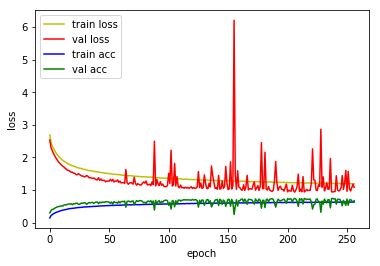

4815/4815 [==============================] - 2s 363us/sample - loss: 0.9860 - acc: 0.7092
Loss: 0.98602715012688 Accuracy: 0.7092419

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.7278 - acc: 0.1344
Epoch 00001: val_loss improved from inf to 2.50811, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_4_conv_checkpoint/001-2.5081.hdf5
36805/36805 [==============================] - 33s 886us/sample - loss: 2.7272 - acc: 0.1345 - val_loss: 2.5081 - val_acc: 0.2732
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.4087 - acc: 0.2309
Epoch 00002: val_loss improved from 2.50811 to 2.18789, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_4_conv_checkpoint/002-2.1879.hdf5
36805/36805 [==============================] - 29s 789us/sample - loss: 2.4086 - acc: 0.2309 - val_loss: 2.1879 - val_acc: 0.3855
Epoch 3/500
36736/36805 [======================

Epoch 22/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.4002 - acc: 0.5618
Epoch 00022: val_loss did not improve from 1.15788
36805/36805 [==============================] - 29s 785us/sample - loss: 1.4003 - acc: 0.5617 - val_loss: 1.1581 - val_acc: 0.6953
Epoch 23/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3733 - acc: 0.5740
Epoch 00023: val_loss improved from 1.15788 to 1.13736, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_4_conv_checkpoint/023-1.1374.hdf5
36805/36805 [==============================] - 29s 791us/sample - loss: 1.3734 - acc: 0.5739 - val_loss: 1.1374 - val_acc: 0.6909
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3653 - acc: 0.5742
Epoch 00024: val_loss improved from 1.13736 to 1.12026, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_4_conv_checkpoint/024-1.1203.hdf5
36805/36805 [==============================] - 29s 792us/sample - loss: 1.36

Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1555 - acc: 0.6428
Epoch 00048: val_loss did not improve from 0.93265
36805/36805 [==============================] - 29s 786us/sample - loss: 1.1557 - acc: 0.6428 - val_loss: 0.9409 - val_acc: 0.7195
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1466 - acc: 0.6443
Epoch 00049: val_loss did not improve from 0.93265
36805/36805 [==============================] - 29s 788us/sample - loss: 1.1465 - acc: 0.6444 - val_loss: 0.9439 - val_acc: 0.7237
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1462 - acc: 0.6491
Epoch 00050: val_loss improved from 0.93265 to 0.87580, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_4_conv_checkpoint/050-0.8758.hdf5
36805/36805 [==============================] - 29s 786us/sample - loss: 1.1461 - acc: 0.6492 - val_loss: 0.8758 - val_acc: 0.7619
Epoch 51/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 1.0630 - acc: 0.6754
Epoch 00074: val_loss improved from 0.82579 to 0.81532, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_4_conv_checkpoint/074-0.8153.hdf5
36805/36805 [==============================] - 29s 792us/sample - loss: 1.0630 - acc: 0.6753 - val_loss: 0.8153 - val_acc: 0.7817
Epoch 75/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0597 - acc: 0.6754
Epoch 00075: val_loss did not improve from 0.81532
36805/36805 [==============================] - 29s 786us/sample - loss: 1.0595 - acc: 0.6754 - val_loss: 1.0631 - val_acc: 0.6548
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0505 - acc: 0.6793
Epoch 00076: val_loss did not improve from 0.81532
36805/36805 [==============================] - 29s 790us/sample - loss: 1.0505 - acc: 0.6793 - val_loss: 0.8433 - val_acc: 0.7612
Epoch 77/500
36736/36805 [============================>.] - ETA: 0s -

Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9979 - acc: 0.6963
Epoch 00102: val_loss did not improve from 0.73165
36805/36805 [==============================] - 29s 786us/sample - loss: 0.9980 - acc: 0.6962 - val_loss: 0.7597 - val_acc: 0.7908
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9966 - acc: 0.6944
Epoch 00103: val_loss did not improve from 0.73165
36805/36805 [==============================] - 29s 791us/sample - loss: 0.9966 - acc: 0.6944 - val_loss: 1.1786 - val_acc: 0.6359
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9875 - acc: 0.6950
Epoch 00104: val_loss did not improve from 0.73165
36805/36805 [==============================] - 29s 786us/sample - loss: 0.9875 - acc: 0.6950 - val_loss: 0.8716 - val_acc: 0.7321
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9874 - acc: 0.6971
Epoch 00105: val_loss did not improve from 0.73165
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.9514 - acc: 0.7082
Epoch 00130: val_loss did not improve from 0.70883
36805/36805 [==============================] - 29s 788us/sample - loss: 0.9514 - acc: 0.7082 - val_loss: 1.0280 - val_acc: 0.6664
Epoch 131/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9564 - acc: 0.7088
Epoch 00131: val_loss did not improve from 0.70883
36805/36805 [==============================] - 29s 791us/sample - loss: 0.9563 - acc: 0.7087 - val_loss: 0.7852 - val_acc: 0.7685
Epoch 132/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9492 - acc: 0.7107
Epoch 00132: val_loss did not improve from 0.70883
36805/36805 [==============================] - 29s 789us/sample - loss: 0.9491 - acc: 0.7107 - val_loss: 0.8207 - val_acc: 0.7517
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9471 - acc: 0.7110
Epoch 00133: val_loss did not improve from 0.70883
36805/36805 [===============

Epoch 158/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9252 - acc: 0.7155
Epoch 00158: val_loss did not improve from 0.67043
36805/36805 [==============================] - 29s 790us/sample - loss: 0.9253 - acc: 0.7154 - val_loss: 0.7264 - val_acc: 0.7918
Epoch 159/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9227 - acc: 0.7202
Epoch 00159: val_loss did not improve from 0.67043
36805/36805 [==============================] - 29s 783us/sample - loss: 0.9227 - acc: 0.7201 - val_loss: 0.7324 - val_acc: 0.7817
Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9223 - acc: 0.7175
Epoch 00160: val_loss did not improve from 0.67043
36805/36805 [==============================] - 29s 787us/sample - loss: 0.9222 - acc: 0.7175 - val_loss: 0.8161 - val_acc: 0.7480
Epoch 161/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9210 - acc: 0.7199
Epoch 00161: val_loss did not improve from 0.67043
36805/36805 [=

Epoch 187/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8976 - acc: 0.7266
Epoch 00187: val_loss did not improve from 0.65860
36805/36805 [==============================] - 29s 784us/sample - loss: 0.8975 - acc: 0.7266 - val_loss: 0.6773 - val_acc: 0.8020
Epoch 188/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8946 - acc: 0.7271
Epoch 00188: val_loss improved from 0.65860 to 0.64300, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_4_conv_checkpoint/188-0.6430.hdf5
36805/36805 [==============================] - 29s 790us/sample - loss: 0.8946 - acc: 0.7271 - val_loss: 0.6430 - val_acc: 0.8258
Epoch 189/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8938 - acc: 0.7282
Epoch 00189: val_loss did not improve from 0.64300
36805/36805 [==============================] - 29s 786us/sample - loss: 0.8939 - acc: 0.7282 - val_loss: 1.1161 - val_acc: 0.6455
Epoch 190/500
36800/36805 [==========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.8765 - acc: 0.7354
Epoch 00215: val_loss did not improve from 0.63775
36805/36805 [==============================] - 29s 784us/sample - loss: 0.8764 - acc: 0.7354 - val_loss: 0.7413 - val_acc: 0.7796
Epoch 216/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8755 - acc: 0.7327
Epoch 00216: val_loss did not improve from 0.63775
36805/36805 [==============================] - 29s 787us/sample - loss: 0.8754 - acc: 0.7327 - val_loss: 1.0449 - val_acc: 0.6699
Epoch 217/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8801 - acc: 0.7312
Epoch 00217: val_loss did not improve from 0.63775
36805/36805 [==============================] - 29s 788us/sample - loss: 0.8801 - acc: 0.7312 - val_loss: 1.3878 - val_acc: 0.5723
Epoch 218/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8758 - acc: 0.7338
Epoch 00218: val_loss did not improve from 0.63775
36805/36805 [===============

Epoch 244/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8569 - acc: 0.7391
Epoch 00244: val_loss did not improve from 0.62815
36805/36805 [==============================] - 29s 781us/sample - loss: 0.8569 - acc: 0.7391 - val_loss: 0.6393 - val_acc: 0.8253
Epoch 245/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8588 - acc: 0.7380
Epoch 00245: val_loss did not improve from 0.62815
36805/36805 [==============================] - 29s 785us/sample - loss: 0.8588 - acc: 0.7380 - val_loss: 0.6536 - val_acc: 0.8081
Epoch 246/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8586 - acc: 0.7383
Epoch 00246: val_loss did not improve from 0.62815
36805/36805 [==============================] - 29s 788us/sample - loss: 0.8589 - acc: 0.7383 - val_loss: 0.7508 - val_acc: 0.7782
Epoch 247/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8634 - acc: 0.7386
Epoch 00247: val_loss did not improve from 0.62815
36805/36805 [=

Epoch 273/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8414 - acc: 0.7432
Epoch 00273: val_loss improved from 0.61404 to 0.61402, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_4_conv_checkpoint/273-0.6140.hdf5
36805/36805 [==============================] - 29s 787us/sample - loss: 0.8415 - acc: 0.7431 - val_loss: 0.6140 - val_acc: 0.8372
Epoch 274/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8432 - acc: 0.7435
Epoch 00274: val_loss did not improve from 0.61402
36805/36805 [==============================] - 29s 785us/sample - loss: 0.8432 - acc: 0.7435 - val_loss: 1.7909 - val_acc: 0.4985
Epoch 275/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8409 - acc: 0.7450
Epoch 00275: val_loss did not improve from 0.61402
36805/36805 [==============================] - 29s 785us/sample - loss: 0.8411 - acc: 0.7450 - val_loss: 0.6155 - val_acc: 0.8279
Epoch 276/500
36800/36805 [==========================

Epoch 301/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8314 - acc: 0.7459
Epoch 00301: val_loss did not improve from 0.58994
36805/36805 [==============================] - 29s 778us/sample - loss: 0.8317 - acc: 0.7459 - val_loss: 0.7464 - val_acc: 0.7654
Epoch 302/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8311 - acc: 0.7461
Epoch 00302: val_loss did not improve from 0.58994
36805/36805 [==============================] - 29s 782us/sample - loss: 0.8311 - acc: 0.7461 - val_loss: 0.6781 - val_acc: 0.8132
Epoch 303/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8284 - acc: 0.7490
Epoch 00303: val_loss did not improve from 0.58994
36805/36805 [==============================] - 29s 781us/sample - loss: 0.8283 - acc: 0.7490 - val_loss: 0.6065 - val_acc: 0.8318
Epoch 304/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8267 - acc: 0.7494
Epoch 00304: val_loss did not improve from 0.58994
36805/36805 [=

Epoch 331/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8178 - acc: 0.7497
Epoch 00331: val_loss did not improve from 0.58994
36805/36805 [==============================] - 29s 779us/sample - loss: 0.8179 - acc: 0.7497 - val_loss: 0.7786 - val_acc: 0.7608
Epoch 332/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8145 - acc: 0.7520
Epoch 00332: val_loss did not improve from 0.58994
36805/36805 [==============================] - 29s 778us/sample - loss: 0.8145 - acc: 0.7520 - val_loss: 0.6308 - val_acc: 0.8132
Epoch 333/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8096 - acc: 0.7518
Epoch 00333: val_loss did not improve from 0.58994
36805/36805 [==============================] - 29s 779us/sample - loss: 0.8096 - acc: 0.7518 - val_loss: 1.0757 - val_acc: 0.6778
Epoch 334/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8085 - acc: 0.7540
Epoch 00334: val_loss did not improve from 0.58994
36805/36805 [=

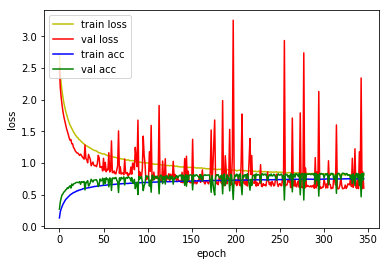

4815/4815 [==============================] - 2s 368us/sample - loss: 0.6497 - acc: 0.8064
Loss: 0.649664846313334 Accuracy: 0.8064382

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5553 - acc: 0.1998
Epoch 00001: val_loss improved from inf to 2.26710, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_5_conv_checkpoint/001-2.2671.hdf5
36805/36805 [==============================] - 36s 968us/sample - loss: 2.5553 - acc: 0.1998 - val_loss: 2.2671 - val_acc: 0.3722
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0967 - acc: 0.3319
Epoch 00002: val_loss improved from 2.26710 to 1.78809, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_5_conv_checkpoint/002-1.7881.hdf5
36805/36805 [==============================] - 30s 821us/sample - loss: 2.0967 - acc: 0.3319 - val_loss: 1.7881 - val_acc: 0.5160
Epoch 3/500
36800/36805 [=====================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9961 - acc: 0.7021
Epoch 00023: val_loss improved from 0.80813 to 0.79144, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_5_conv_checkpoint/023-0.7914.hdf5
36805/36805 [==============================] - 30s 822us/sample - loss: 0.9963 - acc: 0.7021 - val_loss: 0.7914 - val_acc: 0.7892
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9828 - acc: 0.7073
Epoch 00024: val_loss did not improve from 0.79144
36805/36805 [==============================] - 30s 821us/sample - loss: 0.9829 - acc: 0.7073 - val_loss: 1.2078 - val_acc: 0.5926
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9664 - acc: 0.7096
Epoch 00025: val_loss did not improve from 0.79144
36805/36805 [==============================] - 30s 821us/sample - loss: 0.9664 - acc: 0.7097 - val_loss: 0.8301 - val_acc: 0.7591
Epoch 26/500
36800/36805 [============================>.

Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7897 - acc: 0.7682
Epoch 00048: val_loss did not improve from 0.61506
36805/36805 [==============================] - 30s 817us/sample - loss: 0.7898 - acc: 0.7682 - val_loss: 0.6623 - val_acc: 0.8258
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7876 - acc: 0.7682
Epoch 00049: val_loss improved from 0.61506 to 0.59049, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_5_conv_checkpoint/049-0.5905.hdf5
36805/36805 [==============================] - 30s 822us/sample - loss: 0.7876 - acc: 0.7683 - val_loss: 0.5905 - val_acc: 0.8498
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7793 - acc: 0.7693
Epoch 00050: val_loss did not improve from 0.59049
36805/36805 [==============================] - 30s 819us/sample - loss: 0.7793 - acc: 0.7693 - val_loss: 0.6171 - val_acc: 0.8330
Epoch 51/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.6857 - acc: 0.7998
Epoch 00074: val_loss improved from 0.53337 to 0.52518, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_5_conv_checkpoint/074-0.5252.hdf5
36805/36805 [==============================] - 30s 815us/sample - loss: 0.6856 - acc: 0.7998 - val_loss: 0.5252 - val_acc: 0.8661
Epoch 75/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6857 - acc: 0.7982
Epoch 00075: val_loss did not improve from 0.52518
36805/36805 [==============================] - 30s 806us/sample - loss: 0.6855 - acc: 0.7983 - val_loss: 0.5690 - val_acc: 0.8493
Epoch 76/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6853 - acc: 0.7992
Epoch 00076: val_loss improved from 0.52518 to 0.51055, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_5_conv_checkpoint/076-0.5105.hdf5
36805/36805 [==============================] - 30s 819us/sample - loss: 0.6850 - acc: 0.7

36800/36805 [============================>.] - ETA: 0s - loss: 0.6155 - acc: 0.8218
Epoch 00101: val_loss did not improve from 0.46808
36805/36805 [==============================] - 30s 818us/sample - loss: 0.6155 - acc: 0.8218 - val_loss: 0.6577 - val_acc: 0.8025
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6115 - acc: 0.8227
Epoch 00102: val_loss did not improve from 0.46808
36805/36805 [==============================] - 30s 818us/sample - loss: 0.6114 - acc: 0.8227 - val_loss: 0.5800 - val_acc: 0.8197
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6130 - acc: 0.8234
Epoch 00103: val_loss did not improve from 0.46808
36805/36805 [==============================] - 30s 816us/sample - loss: 0.6133 - acc: 0.8233 - val_loss: 0.4795 - val_acc: 0.8733
Epoch 104/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6126 - acc: 0.8216
Epoch 00104: val_loss did not improve from 0.46808
36805/36805 [===============

Epoch 129/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5568 - acc: 0.8385
Epoch 00129: val_loss did not improve from 0.41114
36805/36805 [==============================] - 30s 816us/sample - loss: 0.5573 - acc: 0.8385 - val_loss: 0.5020 - val_acc: 0.8586
Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5565 - acc: 0.8393
Epoch 00130: val_loss did not improve from 0.41114
36805/36805 [==============================] - 30s 819us/sample - loss: 0.5565 - acc: 0.8393 - val_loss: 0.5518 - val_acc: 0.8362
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5483 - acc: 0.8405
Epoch 00131: val_loss did not improve from 0.41114
36805/36805 [==============================] - 30s 820us/sample - loss: 0.5482 - acc: 0.8405 - val_loss: 0.4911 - val_acc: 0.8535
Epoch 132/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5483 - acc: 0.8385
Epoch 00132: val_loss did not improve from 0.41114
36805/36805 [=

Epoch 158/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5131 - acc: 0.8487
Epoch 00158: val_loss did not improve from 0.39160
36805/36805 [==============================] - 30s 816us/sample - loss: 0.5132 - acc: 0.8487 - val_loss: 0.3979 - val_acc: 0.8912
Epoch 159/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5137 - acc: 0.8509
Epoch 00159: val_loss did not improve from 0.39160
36805/36805 [==============================] - 29s 799us/sample - loss: 0.5139 - acc: 0.8509 - val_loss: 0.4084 - val_acc: 0.8870
Epoch 160/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5142 - acc: 0.8497
Epoch 00160: val_loss improved from 0.39160 to 0.37735, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_5_conv_checkpoint/160-0.3773.hdf5
36805/36805 [==============================] - 30s 821us/sample - loss: 0.5144 - acc: 0.8497 - val_loss: 0.3773 - val_acc: 0.8998
Epoch 161/500
36736/36805 [==========================

Epoch 186/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4808 - acc: 0.8604
Epoch 00186: val_loss did not improve from 0.36486
36805/36805 [==============================] - 30s 826us/sample - loss: 0.4808 - acc: 0.8604 - val_loss: 0.3981 - val_acc: 0.8912
Epoch 187/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4826 - acc: 0.8593
Epoch 00187: val_loss did not improve from 0.36486
36805/36805 [==============================] - 31s 829us/sample - loss: 0.4826 - acc: 0.8593 - val_loss: 0.4613 - val_acc: 0.8675
Epoch 188/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4749 - acc: 0.8600
Epoch 00188: val_loss did not improve from 0.36486
36805/36805 [==============================] - 31s 830us/sample - loss: 0.4748 - acc: 0.8602 - val_loss: 0.3948 - val_acc: 0.8921
Epoch 189/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4829 - acc: 0.8599
Epoch 00189: val_loss improved from 0.36486 to 0.35835, saving mo

36800/36805 [============================>.] - ETA: 0s - loss: 0.4512 - acc: 0.8678
Epoch 00214: val_loss did not improve from 0.34946
36805/36805 [==============================] - 30s 825us/sample - loss: 0.4511 - acc: 0.8678 - val_loss: 0.4163 - val_acc: 0.8824
Epoch 215/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4522 - acc: 0.8670
Epoch 00215: val_loss did not improve from 0.34946
36805/36805 [==============================] - 30s 813us/sample - loss: 0.4522 - acc: 0.8670 - val_loss: 0.3610 - val_acc: 0.9005
Epoch 216/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4527 - acc: 0.8669
Epoch 00216: val_loss did not improve from 0.34946
36805/36805 [==============================] - 30s 812us/sample - loss: 0.4527 - acc: 0.8669 - val_loss: 0.3587 - val_acc: 0.9089
Epoch 217/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4462 - acc: 0.8681
Epoch 00217: val_loss did not improve from 0.34946
36805/36805 [===============

Epoch 243/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4272 - acc: 0.8751
Epoch 00243: val_loss did not improve from 0.34406
36805/36805 [==============================] - 30s 829us/sample - loss: 0.4274 - acc: 0.8750 - val_loss: 0.5371 - val_acc: 0.8444
Epoch 244/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4216 - acc: 0.8739
Epoch 00244: val_loss did not improve from 0.34406
36805/36805 [==============================] - 30s 825us/sample - loss: 0.4217 - acc: 0.8738 - val_loss: 0.3696 - val_acc: 0.9012
Epoch 245/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4211 - acc: 0.8760
Epoch 00245: val_loss did not improve from 0.34406
36805/36805 [==============================] - 30s 826us/sample - loss: 0.4214 - acc: 0.8760 - val_loss: 0.3688 - val_acc: 0.9045
Epoch 246/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4265 - acc: 0.8729
Epoch 00246: val_loss did not improve from 0.34406
36805/36805 [=

Epoch 271/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4058 - acc: 0.8787
Epoch 00271: val_loss did not improve from 0.33500
36805/36805 [==============================] - 29s 790us/sample - loss: 0.4059 - acc: 0.8786 - val_loss: 0.4153 - val_acc: 0.8854
Epoch 272/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4068 - acc: 0.8785
Epoch 00272: val_loss did not improve from 0.33500
36805/36805 [==============================] - 29s 795us/sample - loss: 0.4070 - acc: 0.8784 - val_loss: 0.3392 - val_acc: 0.9115
Epoch 273/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4040 - acc: 0.8820
Epoch 00273: val_loss did not improve from 0.33500
36805/36805 [==============================] - 29s 793us/sample - loss: 0.4041 - acc: 0.8819 - val_loss: 0.3927 - val_acc: 0.8891
Epoch 274/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4067 - acc: 0.8786
Epoch 00274: val_loss did not improve from 0.33500
36805/36805 [=

Epoch 300/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3862 - acc: 0.8851
Epoch 00300: val_loss did not improve from 0.32952
36805/36805 [==============================] - 29s 788us/sample - loss: 0.3861 - acc: 0.8851 - val_loss: 0.3645 - val_acc: 0.9031
Epoch 301/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3890 - acc: 0.8827
Epoch 00301: val_loss did not improve from 0.32952
36805/36805 [==============================] - 29s 790us/sample - loss: 0.3889 - acc: 0.8827 - val_loss: 0.4113 - val_acc: 0.8861
Epoch 302/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3837 - acc: 0.8836
Epoch 00302: val_loss did not improve from 0.32952
36805/36805 [==============================] - 29s 788us/sample - loss: 0.3837 - acc: 0.8836 - val_loss: 0.3431 - val_acc: 0.9054
Epoch 303/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3891 - acc: 0.8841
Epoch 00303: val_loss did not improve from 0.32952
36805/36805 [=

Epoch 329/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3722 - acc: 0.8876
Epoch 00329: val_loss did not improve from 0.32739
36805/36805 [==============================] - 29s 790us/sample - loss: 0.3723 - acc: 0.8876 - val_loss: 0.3446 - val_acc: 0.9057
Epoch 330/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3755 - acc: 0.8873
Epoch 00330: val_loss did not improve from 0.32739
36805/36805 [==============================] - 29s 788us/sample - loss: 0.3755 - acc: 0.8873 - val_loss: 0.4264 - val_acc: 0.8821
Epoch 331/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3716 - acc: 0.8901
Epoch 00331: val_loss did not improve from 0.32739
36805/36805 [==============================] - 29s 789us/sample - loss: 0.3719 - acc: 0.8900 - val_loss: 0.3404 - val_acc: 0.9073
Epoch 332/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3718 - acc: 0.8892
Epoch 00332: val_loss improved from 0.32739 to 0.32010, saving mo

Epoch 358/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3617 - acc: 0.8917
Epoch 00358: val_loss did not improve from 0.31736
36805/36805 [==============================] - 29s 786us/sample - loss: 0.3616 - acc: 0.8916 - val_loss: 0.3240 - val_acc: 0.9157
Epoch 359/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3591 - acc: 0.8917
Epoch 00359: val_loss did not improve from 0.31736
36805/36805 [==============================] - 29s 786us/sample - loss: 0.3591 - acc: 0.8916 - val_loss: 0.6205 - val_acc: 0.8190
Epoch 360/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3578 - acc: 0.8925
Epoch 00360: val_loss did not improve from 0.31736
36805/36805 [==============================] - 29s 785us/sample - loss: 0.3580 - acc: 0.8924 - val_loss: 0.3273 - val_acc: 0.9129
Epoch 361/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3632 - acc: 0.8926
Epoch 00361: val_loss did not improve from 0.31736
36805/36805 [=

Epoch 387/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3428 - acc: 0.8961
Epoch 00387: val_loss did not improve from 0.31587
36805/36805 [==============================] - 29s 779us/sample - loss: 0.3428 - acc: 0.8961 - val_loss: 0.3598 - val_acc: 0.9038
Epoch 388/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3486 - acc: 0.8949
Epoch 00388: val_loss did not improve from 0.31587
36805/36805 [==============================] - 29s 780us/sample - loss: 0.3485 - acc: 0.8949 - val_loss: 0.3495 - val_acc: 0.9110
Epoch 389/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3495 - acc: 0.8960
Epoch 00389: val_loss did not improve from 0.31587
36805/36805 [==============================] - 29s 783us/sample - loss: 0.3494 - acc: 0.8960 - val_loss: 0.3171 - val_acc: 0.9196
Epoch 390/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3490 - acc: 0.8942
Epoch 00390: val_loss did not improve from 0.31587
36805/36805 [=

Epoch 416/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3374 - acc: 0.8966
Epoch 00416: val_loss did not improve from 0.31340
36805/36805 [==============================] - 29s 791us/sample - loss: 0.3374 - acc: 0.8965 - val_loss: 0.4866 - val_acc: 0.8588
Epoch 417/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3296 - acc: 0.9004
Epoch 00417: val_loss did not improve from 0.31340
36805/36805 [==============================] - 29s 789us/sample - loss: 0.3297 - acc: 0.9004 - val_loss: 0.3232 - val_acc: 0.9154
Epoch 418/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3333 - acc: 0.8989
Epoch 00418: val_loss did not improve from 0.31340
36805/36805 [==============================] - 29s 790us/sample - loss: 0.3333 - acc: 0.8989 - val_loss: 0.3401 - val_acc: 0.9075
Epoch 419/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3381 - acc: 0.8974
Epoch 00419: val_loss improved from 0.31340 to 0.30913, saving mo

Epoch 445/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3296 - acc: 0.9015
Epoch 00445: val_loss did not improve from 0.30913
36805/36805 [==============================] - 29s 793us/sample - loss: 0.3295 - acc: 0.9015 - val_loss: 0.3216 - val_acc: 0.9159
Epoch 446/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3236 - acc: 0.9010
Epoch 00446: val_loss did not improve from 0.30913
36805/36805 [==============================] - 29s 789us/sample - loss: 0.3243 - acc: 0.9009 - val_loss: 0.4596 - val_acc: 0.8842
Epoch 447/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3243 - acc: 0.9018
Epoch 00447: val_loss did not improve from 0.30913
36805/36805 [==============================] - 29s 791us/sample - loss: 0.3246 - acc: 0.9017 - val_loss: 0.3243 - val_acc: 0.9113
Epoch 448/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3283 - acc: 0.9014
Epoch 00448: val_loss did not improve from 0.30913
36805/36805 [=

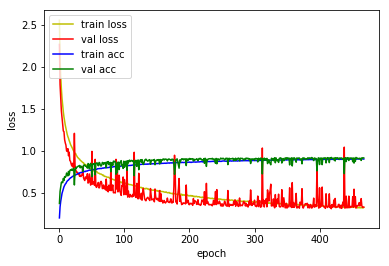

4815/4815 [==============================] - 2s 411us/sample - loss: 0.3813 - acc: 0.8916
Loss: 0.38126937850984827 Accuracy: 0.8915888

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.3542 - acc: 0.2527
Epoch 00001: val_loss improved from inf to 2.08141, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_6_conv_checkpoint/001-2.0814.hdf5
36805/36805 [==============================] - 37s 1ms/sample - loss: 2.3535 - acc: 0.2531 - val_loss: 2.0814 - val_acc: 0.4051
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8488 - acc: 0.4152
Epoch 00002: val_loss improved from 2.08141 to 1.50902, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_6_conv_checkpoint/002-1.5090.hdf5
36805/36805 [==============================] - 30s 810us/sample - loss: 1.8489 - acc: 0.4152 - val_loss: 1.5090 - val_acc: 0.5982
Epoch 3/500
36800/36805 [=====================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6087 - acc: 0.8293
Epoch 00023: val_loss improved from 0.45881 to 0.44431, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_6_conv_checkpoint/023-0.4443.hdf5
36805/36805 [==============================] - 30s 816us/sample - loss: 0.6087 - acc: 0.8293 - val_loss: 0.4443 - val_acc: 0.8852
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5967 - acc: 0.8322
Epoch 00024: val_loss did not improve from 0.44431
36805/36805 [==============================] - 30s 806us/sample - loss: 0.5967 - acc: 0.8322 - val_loss: 0.4618 - val_acc: 0.8859
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5839 - acc: 0.8374
Epoch 00025: val_loss improved from 0.44431 to 0.43647, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_6_conv_checkpoint/025-0.4365.hdf5
36805/36805 [==============================] - 30s 807us/sample - loss: 0.58

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4233 - acc: 0.8779
Epoch 00047: val_loss improved from 0.30386 to 0.29491, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_6_conv_checkpoint/047-0.2949.hdf5
36805/36805 [==============================] - 30s 806us/sample - loss: 0.4233 - acc: 0.8779 - val_loss: 0.2949 - val_acc: 0.9243
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4167 - acc: 0.8800
Epoch 00048: val_loss did not improve from 0.29491
36805/36805 [==============================] - 30s 803us/sample - loss: 0.4167 - acc: 0.8800 - val_loss: 0.3532 - val_acc: 0.9005
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4106 - acc: 0.8811
Epoch 00049: val_loss did not improve from 0.29491
36805/36805 [==============================] - 30s 806us/sample - loss: 0.4106 - acc: 0.8810 - val_loss: 0.3360 - val_acc: 0.9110
Epoch 50/500
36800/36805 [============================>.

Epoch 74/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3324 - acc: 0.9041
Epoch 00074: val_loss did not improve from 0.24602
36805/36805 [==============================] - 30s 804us/sample - loss: 0.3323 - acc: 0.9042 - val_loss: 0.2813 - val_acc: 0.9236
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3285 - acc: 0.9036
Epoch 00075: val_loss did not improve from 0.24602
36805/36805 [==============================] - 30s 807us/sample - loss: 0.3285 - acc: 0.9037 - val_loss: 0.2725 - val_acc: 0.9271
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3235 - acc: 0.9049
Epoch 00076: val_loss did not improve from 0.24602
36805/36805 [==============================] - 30s 806us/sample - loss: 0.3235 - acc: 0.9050 - val_loss: 0.3666 - val_acc: 0.8952
Epoch 77/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3223 - acc: 0.9048
Epoch 00077: val_loss did not improve from 0.24602
36805/36805 [=====

Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2770 - acc: 0.9173
Epoch 00103: val_loss did not improve from 0.22958
36805/36805 [==============================] - 30s 817us/sample - loss: 0.2770 - acc: 0.9173 - val_loss: 0.2726 - val_acc: 0.9231
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2709 - acc: 0.9193
Epoch 00104: val_loss improved from 0.22958 to 0.22501, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_6_conv_checkpoint/104-0.2250.hdf5
36805/36805 [==============================] - 30s 816us/sample - loss: 0.2709 - acc: 0.9193 - val_loss: 0.2250 - val_acc: 0.9415
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2700 - acc: 0.9185
Epoch 00105: val_loss improved from 0.22501 to 0.22079, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_6_conv_checkpoint/105-0.2208.hdf5
36805/36805 [==============================] - 30s 811us/sample - loss: 0

Epoch 131/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2362 - acc: 0.9294
Epoch 00131: val_loss did not improve from 0.21705
36805/36805 [==============================] - 30s 807us/sample - loss: 0.2360 - acc: 0.9295 - val_loss: 0.2215 - val_acc: 0.9383
Epoch 132/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2338 - acc: 0.9291
Epoch 00132: val_loss did not improve from 0.21705
36805/36805 [==============================] - 30s 805us/sample - loss: 0.2339 - acc: 0.9290 - val_loss: 0.2291 - val_acc: 0.9378
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2356 - acc: 0.9306
Epoch 00133: val_loss did not improve from 0.21705
36805/36805 [==============================] - 30s 807us/sample - loss: 0.2357 - acc: 0.9306 - val_loss: 0.2484 - val_acc: 0.9345
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2329 - acc: 0.9321
Epoch 00134: val_loss did not improve from 0.21705
36805/36805 [=

36736/36805 [============================>.] - ETA: 0s - loss: 0.2105 - acc: 0.9354
Epoch 00158: val_loss did not improve from 0.20865
36805/36805 [==============================] - 30s 808us/sample - loss: 0.2108 - acc: 0.9353 - val_loss: 0.2350 - val_acc: 0.9350
Epoch 159/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2105 - acc: 0.9369
Epoch 00159: val_loss did not improve from 0.20865
36805/36805 [==============================] - 30s 809us/sample - loss: 0.2107 - acc: 0.9368 - val_loss: 0.2512 - val_acc: 0.9322
Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2072 - acc: 0.9355
Epoch 00160: val_loss did not improve from 0.20865
36805/36805 [==============================] - 30s 811us/sample - loss: 0.2073 - acc: 0.9355 - val_loss: 0.3646 - val_acc: 0.9019
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2117 - acc: 0.9357
Epoch 00161: val_loss did not improve from 0.20865
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.1888 - acc: 0.9434
Epoch 00187: val_loss did not improve from 0.20715
36805/36805 [==============================] - 31s 836us/sample - loss: 0.1888 - acc: 0.9434 - val_loss: 0.2200 - val_acc: 0.9415
Epoch 188/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1857 - acc: 0.9420
Epoch 00188: val_loss did not improve from 0.20715
36805/36805 [==============================] - 30s 818us/sample - loss: 0.1858 - acc: 0.9420 - val_loss: 0.2093 - val_acc: 0.9441
Epoch 189/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1876 - acc: 0.9429
Epoch 00189: val_loss did not improve from 0.20715
36805/36805 [==============================] - 30s 811us/sample - loss: 0.1877 - acc: 0.9429 - val_loss: 0.2755 - val_acc: 0.9273
Epoch 190/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1860 - acc: 0.9429
Epoch 00190: val_loss did not improve from 0.20715
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.1724 - acc: 0.9481
Epoch 00216: val_loss did not improve from 0.20671
36805/36805 [==============================] - 30s 818us/sample - loss: 0.1724 - acc: 0.9481 - val_loss: 0.2157 - val_acc: 0.9425
Epoch 217/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1748 - acc: 0.9468
Epoch 00217: val_loss did not improve from 0.20671
36805/36805 [==============================] - 30s 821us/sample - loss: 0.1748 - acc: 0.9467 - val_loss: 0.2262 - val_acc: 0.9397
Epoch 218/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1716 - acc: 0.9473
Epoch 00218: val_loss did not improve from 0.20671
36805/36805 [==============================] - 30s 814us/sample - loss: 0.1717 - acc: 0.9473 - val_loss: 0.2312 - val_acc: 0.9432
Epoch 219/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1729 - acc: 0.9465
Epoch 00219: val_loss did not improve from 0.20671
36805/36805 [===============

Epoch 245/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1548 - acc: 0.9530
Epoch 00245: val_loss did not improve from 0.20037
36805/36805 [==============================] - 30s 813us/sample - loss: 0.1548 - acc: 0.9530 - val_loss: 0.2204 - val_acc: 0.9462
Epoch 246/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1544 - acc: 0.9532
Epoch 00246: val_loss did not improve from 0.20037
36805/36805 [==============================] - 30s 821us/sample - loss: 0.1543 - acc: 0.9532 - val_loss: 0.2391 - val_acc: 0.9397
Epoch 247/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1537 - acc: 0.9521
Epoch 00247: val_loss did not improve from 0.20037
36805/36805 [==============================] - 30s 818us/sample - loss: 0.1537 - acc: 0.9520 - val_loss: 0.2185 - val_acc: 0.9457
Epoch 248/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1523 - acc: 0.9523
Epoch 00248: val_loss did not improve from 0.20037
36805/36805 [=


1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_6_conv Model


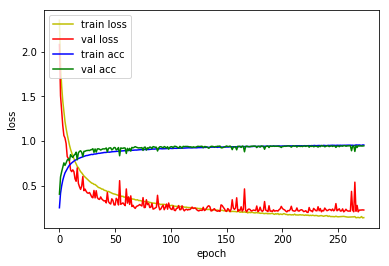

4815/4815 [==============================] - 2s 428us/sample - loss: 0.2341 - acc: 0.9302
Loss: 0.2340986780040856 Accuracy: 0.93021804

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2961 - acc: 0.2758
Epoch 00001: val_loss improved from inf to 1.88348, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_7_conv_checkpoint/001-1.8835.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 2.2961 - acc: 0.2758 - val_loss: 1.8835 - val_acc: 0.4927
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6109 - acc: 0.4992
Epoch 00002: val_loss improved from 1.88348 to 1.14890, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_7_conv_checkpoint/002-1.1489.hdf5
36805/36805 [==============================] - 32s 860us/sample - loss: 1.6108 - acc: 0.4992 - val_loss: 1.1489 - val_acc: 0.7093
Epoch 3/500
36800/36805 [=====================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3277 - acc: 0.9051
Epoch 00023: val_loss did not improve from 0.20389
36805/36805 [==============================] - 32s 860us/sample - loss: 0.3277 - acc: 0.9051 - val_loss: 0.2201 - val_acc: 0.9427
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3159 - acc: 0.9096
Epoch 00024: val_loss improved from 0.20389 to 0.19452, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_7_conv_checkpoint/024-0.1945.hdf5
36805/36805 [==============================] - 32s 865us/sample - loss: 0.3160 - acc: 0.9096 - val_loss: 0.1945 - val_acc: 0.9462
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3086 - acc: 0.9127
Epoch 00025: val_loss improved from 0.19452 to 0.18794, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_7_conv_checkpoint/025-0.1879.hdf5
36805/36805 [==============================] - 32s 861us/sample - loss: 0.30

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1960 - acc: 0.9425
Epoch 00050: val_loss did not improve from 0.15098
36805/36805 [==============================] - 32s 860us/sample - loss: 0.1960 - acc: 0.9425 - val_loss: 0.1596 - val_acc: 0.9553
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1940 - acc: 0.9425
Epoch 00051: val_loss did not improve from 0.15098
36805/36805 [==============================] - 32s 860us/sample - loss: 0.1941 - acc: 0.9425 - val_loss: 0.1550 - val_acc: 0.9534
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1921 - acc: 0.9435
Epoch 00052: val_loss did not improve from 0.15098
36805/36805 [==============================] - 32s 859us/sample - loss: 0.1924 - acc: 0.9435 - val_loss: 0.1605 - val_acc: 0.9527
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1922 - acc: 0.9435
Epoch 00053: val_loss did not improve from 0.15098
36805/36805 [=====

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1385 - acc: 0.9569
Epoch 00078: val_loss did not improve from 0.13901
36805/36805 [==============================] - 32s 862us/sample - loss: 0.1387 - acc: 0.9569 - val_loss: 0.1479 - val_acc: 0.9543
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1357 - acc: 0.9579
Epoch 00079: val_loss did not improve from 0.13901
36805/36805 [==============================] - 32s 865us/sample - loss: 0.1358 - acc: 0.9578 - val_loss: 0.1710 - val_acc: 0.9495
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1388 - acc: 0.9581
Epoch 00080: val_loss did not improve from 0.13901
36805/36805 [==============================] - 32s 863us/sample - loss: 0.1388 - acc: 0.9581 - val_loss: 0.1449 - val_acc: 0.9578
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1303 - acc: 0.9607
Epoch 00081: val_loss did not improve from 0.13901
36805/36805 [=====

Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1035 - acc: 0.9690
Epoch 00108: val_loss did not improve from 0.13901
36805/36805 [==============================] - 32s 860us/sample - loss: 0.1035 - acc: 0.9689 - val_loss: 0.1649 - val_acc: 0.9548
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0999 - acc: 0.9695
Epoch 00109: val_loss did not improve from 0.13901
36805/36805 [==============================] - 32s 862us/sample - loss: 0.0999 - acc: 0.9695 - val_loss: 0.1582 - val_acc: 0.9509
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0980 - acc: 0.9698
Epoch 00110: val_loss did not improve from 0.13901
36805/36805 [==============================] - 32s 867us/sample - loss: 0.0980 - acc: 0.9698 - val_loss: 0.1499 - val_acc: 0.9576
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0989 - acc: 0.9695
Epoch 00111: val_loss did not improve from 0.13901
36805/36805 [=

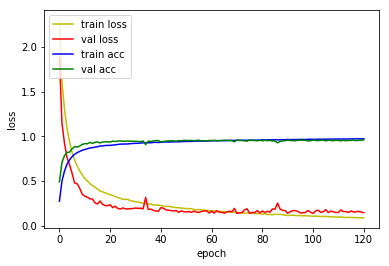

4815/4815 [==============================] - 2s 436us/sample - loss: 0.1892 - acc: 0.9452
Loss: 0.18921934992446335 Accuracy: 0.94517136

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3531 - acc: 0.2720
Epoch 00001: val_loss improved from inf to 1.95835, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_8_conv_checkpoint/001-1.9583.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.3532 - acc: 0.2720 - val_loss: 1.9583 - val_acc: 0.3809
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4407 - acc: 0.5468
Epoch 00002: val_loss improved from 1.95835 to 0.88127, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_8_conv_checkpoint/002-0.8813.hdf5
36805/36805 [==============================] - 34s 921us/sample - loss: 1.4408 - acc: 0.5468 - val_loss: 0.8813 - val_acc: 0.7549
Epoch 3/500
36800/36805 [====================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2048 - acc: 0.9401
Epoch 00023: val_loss did not improve from 0.15502
36805/36805 [==============================] - 33s 903us/sample - loss: 0.2048 - acc: 0.9401 - val_loss: 0.1557 - val_acc: 0.9555
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1988 - acc: 0.9403
Epoch 00024: val_loss did not improve from 0.15502
36805/36805 [==============================] - 33s 901us/sample - loss: 0.1988 - acc: 0.9403 - val_loss: 0.1658 - val_acc: 0.9525
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1955 - acc: 0.9425
Epoch 00025: val_loss did not improve from 0.15502
36805/36805 [==============================] - 33s 904us/sample - loss: 0.1955 - acc: 0.9425 - val_loss: 0.1781 - val_acc: 0.9497
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1845 - acc: 0.9457
Epoch 00026: val_loss did not improve from 0.15502
36805/36805 [=====

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0992 - acc: 0.9690
Epoch 00051: val_loss did not improve from 0.13477
36805/36805 [==============================] - 33s 899us/sample - loss: 0.0994 - acc: 0.9689 - val_loss: 0.1392 - val_acc: 0.9606
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0992 - acc: 0.9692
Epoch 00052: val_loss did not improve from 0.13477
36805/36805 [==============================] - 33s 904us/sample - loss: 0.0993 - acc: 0.9692 - val_loss: 0.1580 - val_acc: 0.9529
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0973 - acc: 0.9708
Epoch 00053: val_loss did not improve from 0.13477
36805/36805 [==============================] - 33s 902us/sample - loss: 0.0974 - acc: 0.9708 - val_loss: 0.1454 - val_acc: 0.9548
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0956 - acc: 0.9697
Epoch 00054: val_loss did not improve from 0.13477
36805/36805 [=====


1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_8_conv Model


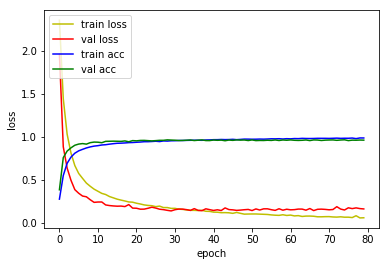

4815/4815 [==============================] - 2s 465us/sample - loss: 0.1823 - acc: 0.9433
Loss: 0.1822829036976318 Accuracy: 0.94330215



In [10]:
base = '1D_CNN_custom_multi_2_GAP_ch_32_DO_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GAP_ch_32_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_33[0][0]  
_________________________________________________________

4815/4815 [==============================] - 2s 458us/sample - loss: 0.6497 - acc: 0.8064
Loss: 0.649664846313334 Accuracy: 0.8064382

1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activat

4815/4815 [==============================] - 2s 517us/sample - loss: 0.2341 - acc: 0.9302
Loss: 0.2340986780040856 Accuracy: 0.93021804

1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activ

4815/4815 [==============================] - 3s 536us/sample - loss: 0.1823 - acc: 0.9433
Loss: 0.1822829036976318 Accuracy: 0.94330215


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_33[0][0]  
_________________________________________________________

4815/4815 [==============================] - 3s 544us/sample - loss: 0.6646 - acc: 0.8023
Loss: 0.6645504071952646 Accuracy: 0.80228454

1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activ

4815/4815 [==============================] - 3s 597us/sample - loss: 0.2667 - acc: 0.9211
Loss: 0.2666606889397432 Accuracy: 0.92107993

1D_CNN_custom_multi_2_GAP_ch_32_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activ

4815/4815 [==============================] - 3s 663us/sample - loss: 0.2015 - acc: 0.9448
Loss: 0.20153303648638204 Accuracy: 0.944756
